In [ ]:
# 1. Install dependencies
!pip install -q transformers sentencepiece torch torchvision torchaudio
!pip install -q googletrans==4.0.0-rc1 textblob
!pip install -q matplotlib seaborn



In [ ]:
# 2. Imports
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from googletrans import Translator
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [ ]:
# 3. Load multilingual emotion model
# For demo purposes we use an English-emotion model. You can replace with a multilingual fine-tuned model later.
EMOTION_MODEL_NAME = "j-hartmann/emotion-english-distilroberta-base"  # English only
tokenizer = AutoTokenizer.from_pretrained(EMOTION_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(EMOTION_MODEL_NAME)
emotion_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True, device=0 if torch.cuda.is_available() else -1)

# Define emotion labels from model config
labels = model.config.id2label if hasattr(model.config, "id2label") else None
print("Loaded emotion model:", EMOTION_MODEL_NAME)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Loaded emotion model: j-hartmann/emotion-english-distilroberta-base


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# 4. Utility functions

translator = Translator()

def detect_language(text):
    try:
        res = translator.detect(text)
        return res.lang
    except Exception as e:
        print("Lang detect error:", e)
        return None

def translate_to_english(text, src_lang):
    if src_lang != 'en':
        try:
            res = translator.translate(text, src='auto', dest='en')
            return res.text
        except Exception as e:
            print("Translate error:", e)
            return text
    return text

def predict_emotion(text):
    # returns sorted list of (label, score)
    results = emotion_pipeline(text)
    scores = results[0]
    sorted_scores = sorted(scores, key=lambda x: x['score'], reverse=True)
    return sorted_scores

def predict_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0.1:
        sentiment = "positive"
    elif polarity < -0.1:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    return sentiment, polarity

def plot_top_emotions(sorted_scores, topk=5):
    labels_top = [r['label'] for r in sorted_scores[:topk]]
    scores_top = [r['score'] for r in sorted_scores[:topk]]
    sns.set_style("whitegrid")
    plt.figure(figsize=(6,3))
    sns.barplot(x=scores_top, y=labels_top, palette="coolwarm")
    plt.title("Top emotion probabilities")
    plt.xlabel("Score")
    plt.show()


Input text: मैं इस उत्पाद से बहुत खुश हूँ
Detected language: hi
Translated to English (if needed): I am very happy with this product
Top emotions: [{'label': 'joy', 'score': 0.9907068610191345}, {'label': 'surprise', 'score': 0.0046913521364331245}, {'label': 'neutral', 'score': 0.001443610992282629}]


/tmp/ipython-input-344835037.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores_top, y=labels_top, palette="coolwarm")


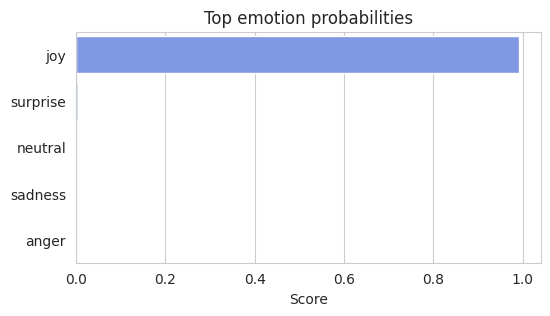

Sentiment: positive | Polarity: 1.0
{'input': 'मैं इस उत्पाद से बहुत खुश हूँ', 'language': 'hi', 'translated': 'I am very happy with this product', 'emotion_top': [{'label': 'joy', 'score': 0.9907068610191345}, {'label': 'surprise', 'score': 0.0046913521364331245}, {'label': 'neutral', 'score': 0.001443610992282629}], 'sentiment': 'positive', 'polarity_score': 1.0}


In [ ]:
# 5. Demo: Accept text in multiple languages and analyse

def analyze_text_multilingual(user_text):
    print("Input text:", user_text)
    lang = detect_language(user_text)
    print("Detected language:", lang)
    eng_text = translate_to_english(user_text, lang)
    print("Translated to English (if needed):", eng_text)

    emotion_scores = predict_emotion(eng_text)
    print("Top emotions:", emotion_scores[:3])
    plot_top_emotions(emotion_scores)

    sentiment, polarity_score = predict_sentiment(eng_text)
    print("Sentiment:", sentiment, "| Polarity:", round(polarity_score,2))
    return {
        "input": user_text,
        "language": lang,
        "translated": eng_text,
        "emotion_top": emotion_scores[:3],
        "sentiment": sentiment,
        "polarity_score": round(polarity_score,2)
    }

# Example usage
result = analyze_text_multilingual("मैं इस उत्पाद से बहुत खुश हूँ")  # Hindi: "I am very happy with this product"
print(result)


------
Input text: This mobile phone is fantastic, value for money!
Detected language: en
Translated to English (if needed): This mobile phone is fantastic, value for money!
Top emotions: [{'label': 'joy', 'score': 0.8208375573158264}, {'label': 'neutral', 'score': 0.10778804868459702}, {'label': 'surprise', 'score': 0.05835644155740738}]


/tmp/ipython-input-344835037.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores_top, y=labels_top, palette="coolwarm")


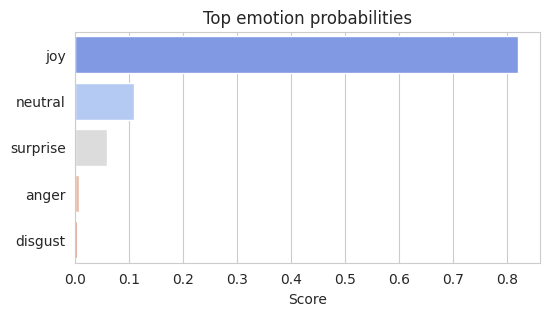

Sentiment: positive | Polarity: 0.5
------
Input text: இந்த தயாரிப்பு மிகவும் மோசமானது, பணம் வீணாகியது
Detected language: ta
Translated to English (if needed): This product is very bad, waste of money
Top emotions: [{'label': 'disgust', 'score': 0.9540531635284424}, {'label': 'anger', 'score': 0.02712993510067463}, {'label': 'sadness', 'score': 0.008854181505739689}]


/tmp/ipython-input-344835037.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores_top, y=labels_top, palette="coolwarm")


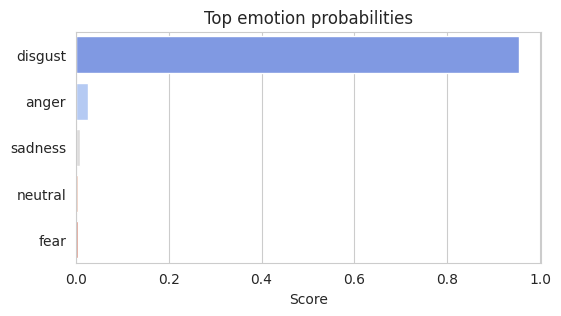

Sentiment: negative | Polarity: -0.55
------
Input text: I regret buying this. Poor quality and no support.
Detected language: en
Translated to English (if needed): I regret buying this. Poor quality and no support.
Top emotions: [{'label': 'sadness', 'score': 0.9244396090507507}, {'label': 'disgust', 'score': 0.03219345211982727}, {'label': 'neutral', 'score': 0.023226318880915642}]


/tmp/ipython-input-344835037.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores_top, y=labels_top, palette="coolwarm")


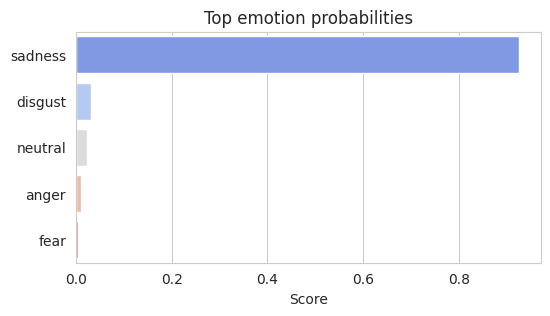

Sentiment: negative | Polarity: -0.4
------
Input text: നിങ്ങളുടെ സേവനം വളരെ മഹത്താണ്, നന്ദി!
Detected language: ml
Translated to English (if needed): Your service is great, thank you!
Top emotions: [{'label': 'joy', 'score': 0.9421906471252441}, {'label': 'neutral', 'score': 0.027857663109898567}, {'label': 'surprise', 'score': 0.01762492209672928}]


/tmp/ipython-input-344835037.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores_top, y=labels_top, palette="coolwarm")


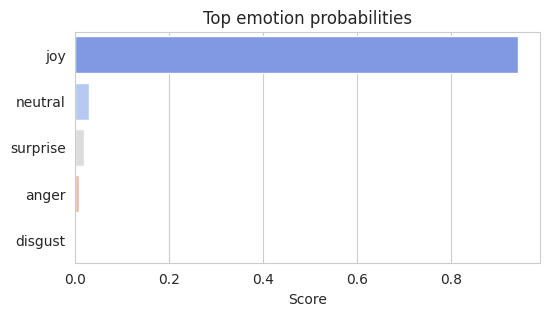

Sentiment: positive | Polarity: 1.0
------
Input text: ఈ ఉత్పత్తి నన్ను నిరాశపరిచింది.
Detected language: te
Translated to English (if needed): This product disappointed me.
Top emotions: [{'label': 'sadness', 'score': 0.8680185675621033}, {'label': 'disgust', 'score': 0.04466518014669418}, {'label': 'neutral', 'score': 0.042545612901449203}]


/tmp/ipython-input-344835037.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores_top, y=labels_top, palette="coolwarm")


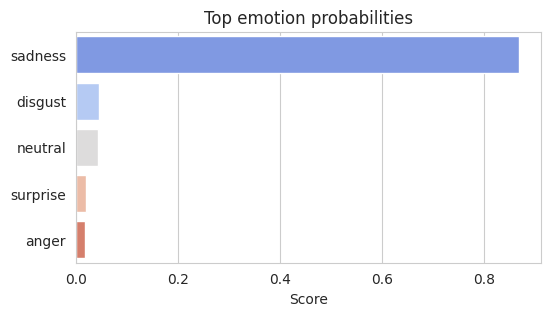

Sentiment: negative | Polarity: -0.75


In [ ]:
# 6. E-commerce domain example: analyzing multiple reviews
reviews = [
    "This mobile phone is fantastic, value for money!",
    "இந்த தயாரிப்பு மிகவும் மோசமானது, பணம் வீணாகியது",  # Tamil: "This product is very bad, money wasted"
    "I regret buying this. Poor quality and no support.",
    "നിങ്ങളുടെ സേവനം വളരെ മഹത്താണ്, നന്ദി!",  # Malayalam: "Your service is excellent, thank you!"
    "ఈ ఉత్పత్తి నన్ను నిరాశపరిచింది.",  # Telugu: "This product disappointed me."
]

for rev in reviews:
    print("------")
    analyze_text_multilingual(rev)
